<a href="https://colab.research.google.com/github/raihanewubd/selfSupervised/blob/main/i_jepa_aav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers[torch] # add torch for required GPU computation

In [ ]:
from google.colab import drive
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTImageProcessor
from collections import Counter
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import timm
import matplotlib.pyplot as plt
import copy

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/AAVDATASET/spectrogram'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# Test loading
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)  # Should be [B, C, 224, 224]

Batch shape: torch.Size([16, 3, 224, 224])


In [ ]:
batch_size = 32
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


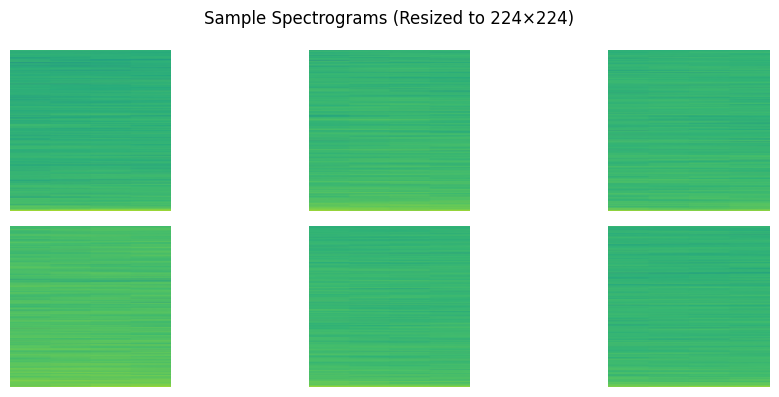

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(6):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze(), cmap='viridis')
    plt.axis('off')
plt.suptitle("Sample Spectrograms (Resized to 224×224)")
plt.tight_layout()
plt.show()

In [ ]:
def generate_block_mask(grid_size=14, mask_ratio=0.4, block_size_range=(2, 6)):
    total_patches = grid_size * grid_size
    num_masked = int(mask_ratio * total_patches)

    mask = np.zeros((grid_size, grid_size), dtype=bool)

    while mask.sum() < num_masked:
        bh = np.random.randint(*block_size_range)
        bw = np.random.randint(*block_size_range)
        top = np.random.randint(0, grid_size - bh + 1)
        left = np.random.randint(0, grid_size - bw + 1)

        mask[top:top+bh, left:left+bw] = True

    return mask

# Example usage:
grid_mask = generate_block_mask(grid_size=14, mask_ratio=0.4)
print("Masked patches:", grid_mask.sum())

Masked patches: 81


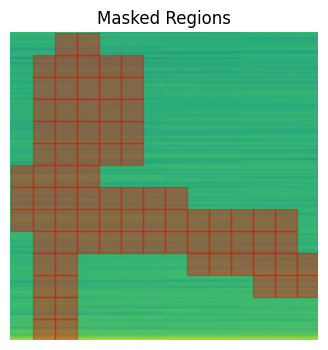

In [ ]:
def show_patch_mask(image_tensor, mask, patch_size=16):
    image = image_tensor.permute(1, 2, 0).detach().cpu().numpy()
    image = (image * 0.5) + 0.5  # unnormalize

    plt.figure(figsize=(4, 4))
    plt.imshow(image.squeeze(), cmap='viridis')

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                y0, x0 = i * patch_size, j * patch_size
                rect = plt.Rectangle((x0, y0), patch_size, patch_size, edgecolor='red', facecolor='red', alpha=0.4)
                plt.gca().add_patch(rect)

    plt.axis('off')
    plt.title("Masked Regions")
    plt.show()

# Example: visualize mask over first image in batch
show_patch_mask(images[0], grid_mask)

In [ ]:
class MaskedViTEncoder(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', pretrained=True):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)  # remove classification head
        self.patch_embed = self.vit.patch_embed
        self.pos_embed = self.vit.pos_embed  # [1, 197, D]
        self.blocks = self.vit.blocks
        self.norm = self.vit.norm
        self.cls_token = self.vit.cls_token

    def forward(self, x, mask):
        B = x.size(0)
        # Step 1: embed patches
        x = self.patch_embed(x)  # (B, num_patches, D)

        # Step 2: add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + N, D)

        # Step 3: add positional embeddings
        x = x + self.pos_embed[:, :x.size(1)]

        # Step 4: mask tokens (leave class token, mask others)
        # mask shape: (B, N_patches), bool → unmasked = ~mask
        mask = mask.to(x.device)
        visible = torch.cat([torch.ones((B, 1), dtype=torch.bool).to(x.device), ~mask], dim=1)  # include CLS token

        x = [xi[vi] for xi, vi in zip(x, visible)]  # variable-length batch → list of tensors

        # ViT blocks need padding to equal length; pad to max
        max_len = max([xi.size(0) for xi in x])
        x_padded = torch.stack([F.pad(xi, (0, 0, 0, max_len - xi.size(0))) for xi in x])  # (B, max_len, D)

        # Feed through transformer blocks
        for blk in self.blocks:
            x_padded = blk(x_padded)
        x_padded = self.norm(x_padded)

        return x_padded  # [B, max_len, D] → includes CLS + visible patches

In [ ]:
encoder = MaskedViTEncoder().to('cuda')
images = images.to('cuda')  # shape: [B, 3, 224, 224]

# Convert grid mask to flat mask per image
B = images.shape[0]
mask_grid = torch.stack([torch.from_numpy(generate_block_mask()).flatten() for _ in range(B)]).bool()

with torch.no_grad():
    context_features = encoder(images, mask_grid)
print("Encoded shape:", context_features.shape)


Encoded shape: torch.Size([16, 119, 768])


In [ ]:
def update_ema(target_model, online_model, m=0.996):
    for param_q, param_k in zip(online_model.parameters(), target_model.parameters()):
        param_k.data = m * param_k.data + (1. - m) * param_q.data

In [ ]:
class Predictor(nn.Module):
    def __init__(self, in_dim=768, hidden_dim=2048, out_dim=768):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
def ijepa_loss(pred_feat, target_feat, mask):
    B, N, D = pred_feat.shape
    loss = 0.0
    for b in range(B):
        try:
            masked_indices = mask[b].nonzero(as_tuple=True)[0]
            if masked_indices.numel() == 0:
                continue

            # Check for shape mismatches before computing loss
            pred = pred_feat[b][masked_indices]
            targ = target_feat[b][masked_indices]

            if pred.shape != targ.shape:
                print(f"[!] Shape mismatch: pred {pred.shape}, target {targ.shape}, mask sum: {mask[b].sum()}")
                continue

            if torch.isnan(pred).any() or torch.isnan(targ).any():
                print(f"[!] NaNs detected in batch {b}")
                continue

            loss += F.mse_loss(pred, targ)
        except Exception as e:
            print(f"Error at batch index {b}: {e}")
            continue

    return loss / B


In [ ]:
print("Predicted:", predicted_feat.shape)
print("Target:", target_feat.shape)
print("Mask:", mask.shape)

assert predicted_feat.shape == target_feat.shape, "Shape mismatch in features!"
assert predicted_feat.shape[:2] == mask.shape, "Batch and patch dims must align!"


Predicted: torch.Size([16, 118, 768])
Target: torch.Size([16, 196, 768])
Mask: torch.Size([16, 196])


AssertionError: Shape mismatch in features!

In [ ]:
# Initialize encoder (from Step 3), predictor, and target encoder
encoder = MaskedViTEncoder().to('cuda')
predictor_net = Predictor(in_dim=768).to('cuda')

# Create target encoder (EMA of online encoder)
encoder_ema = copy.deepcopy(encoder).to('cuda')
for p in encoder_ema.parameters():
    p.requires_grad = False


In [ ]:
images = images.to('cuda')  # [B, 3, 224, 224]

# Generate a patch-wise mask (True = masked)
mask = torch.stack([torch.from_numpy(generate_block_mask()).flatten() for _ in range(images.size(0))]).bool().to(images.device)

# 1. Online encoder (context) → unmasked patches
context_feat = encoder(images, mask)[:, 1:]  # exclude CLS token

# 2. Predictor
predicted_feat = predictor_net(context_feat)

# 3. Target encoder (full image, no masking)
with torch.no_grad():
    full_mask = torch.zeros_like(mask).bool()
    target_feat = encoder_ema(images, mask=full_mask)[:, 1:]  # exclude CLS token

# 4. Compute I-JEPA loss
loss = ijepa_loss(predicted_feat, target_feat, mask)

# 5. Backward + update
optimizer.zero_grad()
loss.backward()
optimizer.step()

# 6. Update target encoder with EMA
update_ema(encoder_ema, encoder, m=0.996)

print("Loss:", loss.item())



RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#others

In [ ]:
from collections import Counter
import numpy as np
from tqdm import tqdm  # Add this import

# Get class names from the dataset
class_names = dataset.classes

# Extract targets (labels) from the original dataset
all_labels = np.array([sample[1] for sample in tqdm(dataset, desc="Extracting all labels")])

# Get indices from train and val datasets (random_split returns Subsets)
train_indices = train_dataset.indices if hasattr(train_dataset, 'indices') else train_dataset.dataset.indices
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else val_dataset.dataset.indices

# Use tqdm while extracting subset labels
train_labels = np.array([all_labels[i] for i in tqdm(train_indices, desc="Processing train labels")])
val_labels = np.array([all_labels[i] for i in tqdm(val_indices, desc="Processing val labels")])

# Count labels with tqdm for display
print("Training Set Distribution:")
for class_idx in tqdm(train_dist := Counter(train_labels), desc="Counting train distribution"):
    print(f"  {class_names[class_idx]}: {train_dist[class_idx]} images")

print("\nValidation Set Distribution:")
for class_idx in tqdm(val_dist := Counter(val_labels), desc="Counting val distribution"):
    print(f"  {class_names[class_idx]}: {val_dist[class_idx]} images")


Processing val labels: 100%|██████████| 703/703 [00:00<00:00, 1254187.88it/s]


Training Set Distribution:


Counting train distribution: 100%|██████████| 3/3 [00:00<00:00, 16754.88it/s]


  empty: 735 images
  double: 821 images
  single: 1254 images

Validation Set Distribution:


Counting val distribution: 100%|██████████| 3/3 [00:00<00:00, 24291.34it/s]

  double: 214 images
  single: 302 images
  empty: 187 images


In [ ]:
import os
import shutil
from tqdm import tqdm

# Define source and destination folders
source_dir = '/content/drive/MyDrive/AAVDATASET/spectrogram'      # replace with your actual folder
target_dir = '/content/target_folder'                    # or any path in Colab

# Create destination folder if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# List all files in source
file_list = os.listdir(source_dir)

# Copy with progress bar
for fname in tqdm(file_list, desc="Copying files"):
    src_path = os.path.join(source_dir, fname)
    dst_path = os.path.join(target_dir, fname)
    if os.path.isfile(src_path):  # ensure it's a file
        shutil.copy(src_path, dst_path)


Copying files: 100%|██████████| 3/3 [00:00<00:00, 4748.27it/s]


In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=3)
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

RuntimeError: Error(s) in loading state_dict for ViTForImageClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([1000, 768]) from checkpoint, the shape in current model is torch.Size([3, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([3]).

In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                      num_labels=3,
                                                      ignore_mismatched_sizes=True)
                                                      # Ignore size mismatches between
                                                      # pre-trained and your model.
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]